# Практическое задание №1

Цель работы - решение задач компьютерного зрения в системах управления с использованием предобученных моделей сверточных нейронных сетей из библиотеки PyTorch (см. https://pytorch.org/vision/stable/models.html).

Преимущество предобученных моделей - получение быстрого результата без погружения в детали реализации и выполнения трудоемкого процесса настройки на крупных библиотеках изображений.

Их недостатоки - возможны ограничения лицензий использования как на использованный при обучении набор данных, так и на сами коэффициенты из библиотеки и исходный код модели. Ещё одним недостатком является то, что такие весовые коэффицпенты расчитываются на публичных библиотеках изображений и зачастую могут оказаться нерелеванты решаемой задаче.

Последнюю проблему обычно решают с помощью набора приемов, известных в англоязычной литературе как "Transfer learning". Суть его состоит в использовании библиотечных коэффициентов и модели как базы для настройки новой модели.

Ниже будет проиллюстрировано решение задач классификации и донастройки модели с использованием библиотеки PyTorch.

## 1. Инициализация преднастроенных нейросетевых моделей

In [28]:
from torchvision import models

alexNet = {
    # https://papers.nips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html
    'model': models.alexnet(weights=models.AlexNet_Weights.DEFAULT),
    'weights': models.AlexNet_Weights.DEFAULT,
    'preprocess': models.AlexNet_Weights.DEFAULT.transforms()
}

resNet50 = {
    # https://arxiv.org/abs/1512.03385
    'model': models.resnet50(weights=models.ResNet50_Weights.DEFAULT),
    'weights': models.ResNet50_Weights.DEFAULT,
    'preprocess': models.ResNet50_Weights.DEFAULT.transforms()
}

denseNet = {
    # https://arxiv.org/abs/1608.06993
    'model': models.densenet201(weights=models.DenseNet201_Weights.DEFAULT),
    'weights': models.DenseNet201_Weights.DEFAULT,
    'preprocess': models.DenseNet201_Weights.DEFAULT.transforms()
}



In [29]:
for model in [resNet50, alexNet, denseNet]:
    model['model'].eval()

## Вспомогательные функции

In [119]:
from pandas.core.arrays import boolean
import typing
import matplotlib.pyplot as plt
import torch
import numpy
from torchvision.io import read_image
from requests import get
from torchvision.transforms import ToPILImage, Compose, Resize, CenterCrop
from torch.utils.data import Dataset
from torch import Tensor
import os
import pandas
from torch.utils.data import Dataset
from torchvision.io import read_image
import time
import copy
import math
from torch import Tensor
from typing import Callable
from functools import partial


strip_chars = ' \t'
tmp_file_name = 'tmp_file_name_for_image_download'

to_image = ToPILImage()


def classify(model, weights, transformation, image, num_of_classes: int) -> torch.Tensor:
    preprocessed = transformation(image)
    batch = preprocessed.unsqueeze(0)
    result = model(batch).squeeze(0).softmax(0)
    scores = result.cpu().detach().numpy()
    class_list = numpy.flip(scores.argsort())[0:num_of_classes]
    caption = ""
    for class_id in class_list:
        score = result[class_id].item()
        category_name = weights.meta["categories"][class_id]
        caption = f"{caption}\n{category_name}: {100 * score:.1f}%"
    to_target = Compose([Resize(transformation.resize_size), CenterCrop(transformation.crop_size)])
    plt.figure()
    plt.imshow(to_image(to_target(image)))
    plt.title(caption)
    return result


def process(model, urls: str, num_of_classes: int) -> typing.List[dict]:
    count = 0
    strip_chars = ' \t'
    url_list = [url.strip(strip_chars) for url in urls.splitlines() if len(url.strip(strip_chars)) > 0]
    result = []
    for url in url_list:
        meta = {}
        meta['file'] = str(count)
        meta['url'] = url
        with open(meta['file'], 'wb') as file:
            file.write(get(meta['url']).content)
        meta['image'] = read_image(meta['file'])
        meta['result'] = classify(model['model'], model['weights'], model['preprocess'], meta['image'], num_of_classes)
        result.append(meta)
        ++count
    return result


def plot_images(dataset: Dataset, 
                preprocess: typing.Callable[[Tensor],Tensor],
                num_per_row: int, single_size: int, 
                labels: typing.List[str],
                model_labels: typing.List[str] = None,
                model: typing.Callable[[Tensor], Tensor] = None,
                debug: boolean = False) -> None:
    num = len(dataset)
    fig, axs = plt.subplots(math.ceil(num/num_per_row), num_per_row, figsize=(
        single_size*num_per_row, single_size*math.ceil(num/num_per_row)),
        sharex=True, sharey=True)
    for i in range(0, len(dataset)):
        try:
            image, label = dataset[i]
            pred = None
            
            if model is not None and model_labels is not None:
                _, pred_index = torch.max(model(image.unsqueeze(0)), 1)
                pred = f'{model_labels[pred_index]}({pred_index.item()})'
            
            loc_fig = axs[i//num_per_row, i % num_per_row]
            loc_fig.imshow(to_image(preprocess(image)))
            title =f'\nActual: {labels[label]}({label})\nModel: {pred}'
            loc_fig.title.set_text(title)
        except Exception as ex:
            if debug is True:
                raise ex
            print(f'Image {i} is failed to load: {str(ex)}')

    fig.subplots_adjust(wspace=0.3)
    plt.show()


def denormalize(dataset: Dataset, trans: typing.Any) -> Callable[[Tensor], Tensor]:
    image, label = dataset[0]
    std = torch.as_tensor(trans.std, dtype=image.dtype, device=image.device).view(-1, 1, 1)
    mean = torch.as_tensor(trans.mean, dtype=image.dtype, device=image.device).view(-1, 1, 1)
    return lambda img: img*std + mean


class UrlDataset(Dataset):

    def __init__(self, file: str, transform = None) -> None:
        self.file = file
        self.transform = transform
        self.dataset = pandas.read_csv(file, sep=';')
        self.classes = self.dataset['label'].unique()
        self.classes.sort()
        self.class_to_index = {self.classes[i] : i for i in range(len(self.classes))}

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, index: int) -> typing.Tuple[torch.Tensor, str]:
        url = self.dataset.iloc[index]['url'].strip(strip_chars)
        with open(tmp_file_name, 'wb') as file:
            file.write(get(url).content)
        image = read_image(tmp_file_name)
        label = self.class_to_index[self.dataset.iloc[index]['label']]
        if self.transform:
            return self.transform(image), label
        return image, label


def train_model(model, dataloader: DataLoader, device: torch.device, 
                criterion, optimizer, scheduler, num_epochs=25) -> None:
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        for item in dataloader:
            if item['train'] == True:
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in item['loader']:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(item['train'] == True):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if item['train'] == True:
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if item['train'] == True:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if item['train'] == True and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

gpu = 'has' if torch.cuda.is_available() else 'has no'
print(f'Current environment {gpu} GPU support')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Current environment has no GPU support


## Пример описания данных для классификации

В практическом задании набор данных (датасет) формализуется в виде CSV-файла, содержащего URL изображения из интернета и вручную назначенных меток объектов (названий классов), к которому каждое изображение относится.

In [113]:
%%writefile simple.csv
label;url
?;https://i03.fotocdn.net/s119/9c4a25d1afe85016/public_pin_l/2730300326.jpg
?;https://pp.userapi.com/c639429/v639429799/1b423/EWqrUsA86vo.jpg
?;https://cdn1.jigidi.com/thumbs/CTU9QFYI/l
?;https://wallbox.ru/resize/320x240/wallpapers/main2/201716/kotenok-seryj.jpg
?;http://images4.fanpop.com/image/photos/14700000/So-cute-puppies-14749028-800-600.jpg
?;https://calendario.su/wp-content/uploads/2020/03/calendario-con-sfondo-12.jpg
?;https://fs02.vseosvita.ua/0200otf2-181d.jpg'
?;https://st14.stpulscen.ru/images/localized/012/859/486_original.jpg
?;https://img.youtube.com/vi/ZaxuckqnMZ0/0.jpg?3489220329
?;https://vpm-parts.ru/800/600/https/konspekta.net/lectmaniaru/baza1/43058697973.files/image017.jpg
?;https://prombrand.ru/wp-content/uploads/konveernye-sistemy-soco-system.jpg
?;https://avcdn.av.by/wisiwigimage/0000/5926/8164.jpeg
?;https://vsegda-pomnim.com/uploads/posts/2022-04/1650639754_84-vsegda-pomnim-com-p-kak-tsvetet-khlorofitum-foto-97.jpg
?;https://wallpapersprinted.com/cache/thumbnails/71/97/80/fresh_wheat_field-t1.jpg
?;https://img1.goodfon.ru/original/640x480/b/f1/pole-derevo-svet.jpg
?;https://img.promportal.su/foto/good_fotos/134/1343535/prodayu-zernouborochniy-kombayn-acros-580-proizvodstva-kompanii-rostselmash_foto_largest.jpg
?;https://krot.info/uploads/posts/2021-10/1634950348_39-krot-info-p-mashina-begemotik-mashini-krasivo-foto-41.jpg
?;https://www.claas.de/blueprint/servlet/resource/image/1788044/inline_m_s/400/225/ab80e51c5f27c04b19feaa70e35f574d/BO/332463.jpg
?;https://pw.artfile.me/wallpaper/02-07-2015/344x230/tehnika-kombajny-kombajn-pole-zhatva-945905.jpg
?;https://17.img.avito.st/640x480/8813699217.jpg
?;https://pw.artfile.me/wallpaper/30-05-2018/650x434/tehnika-kombajny-pole-kombajn-1347902.jpg
?;https://p0.pikist.com/photos/1011/420/goat-petting-zoo-animal-zoo-domestic-goat-horns-lazing-around-sun-goat-s-head-thumbnail.jpg
?;https://banzay.ru/files/4-28-768x513.jpg
?;https://i.ytimg.com/vi/eMqIVGGBlps/maxresdefault.jpg
?;https://sad-deco.ru/image/cache/catalog/figuri_unikal/sadovaja_figura_korovka-800x800.jpg
?;https://woolmerino.ru/wa-data/public/shop/img/ovca_yagnenok_detenysh_mama_sherst_41653_2048x1152-768x4321.jpg
?;http://www.hereinuk.com/wp-content/uploads/2016/09/pink-sheep.jpg
?;https://i.ytimg.com/vi/GE12O7fdUq8/hqdefault.jpg
?;https://tolksnov.ru/assets/i/ai/4/1/1/i/2739788.jpg
?;https://bugaga.ru/uploads/posts/2015-12/1449839466_neobychnye-koncept-kary.jpg
?;https://i.pinimg.com/736x/a6/ee/4d/a6ee4d8fe4cbf0d3de574d91a3611bb2.jpg
?;https://baomoi-photo-fbcrawler.zadn.vn/w720x480/2016_04_17_207_19148788/e36560b2b0f259ac00e3.jpg
?;https://www.pavelzubek.cz/photos/elektricka-obloukova-pec-524.jpg
?;http://xt.ht/article/2708/imgm/000003-t.jpg
?;https://krd.autoservice-catalog.ru/upload/usl/f_61eaf149aa336.jpg

Overwriting simple.csv


## Решение задачи классификации

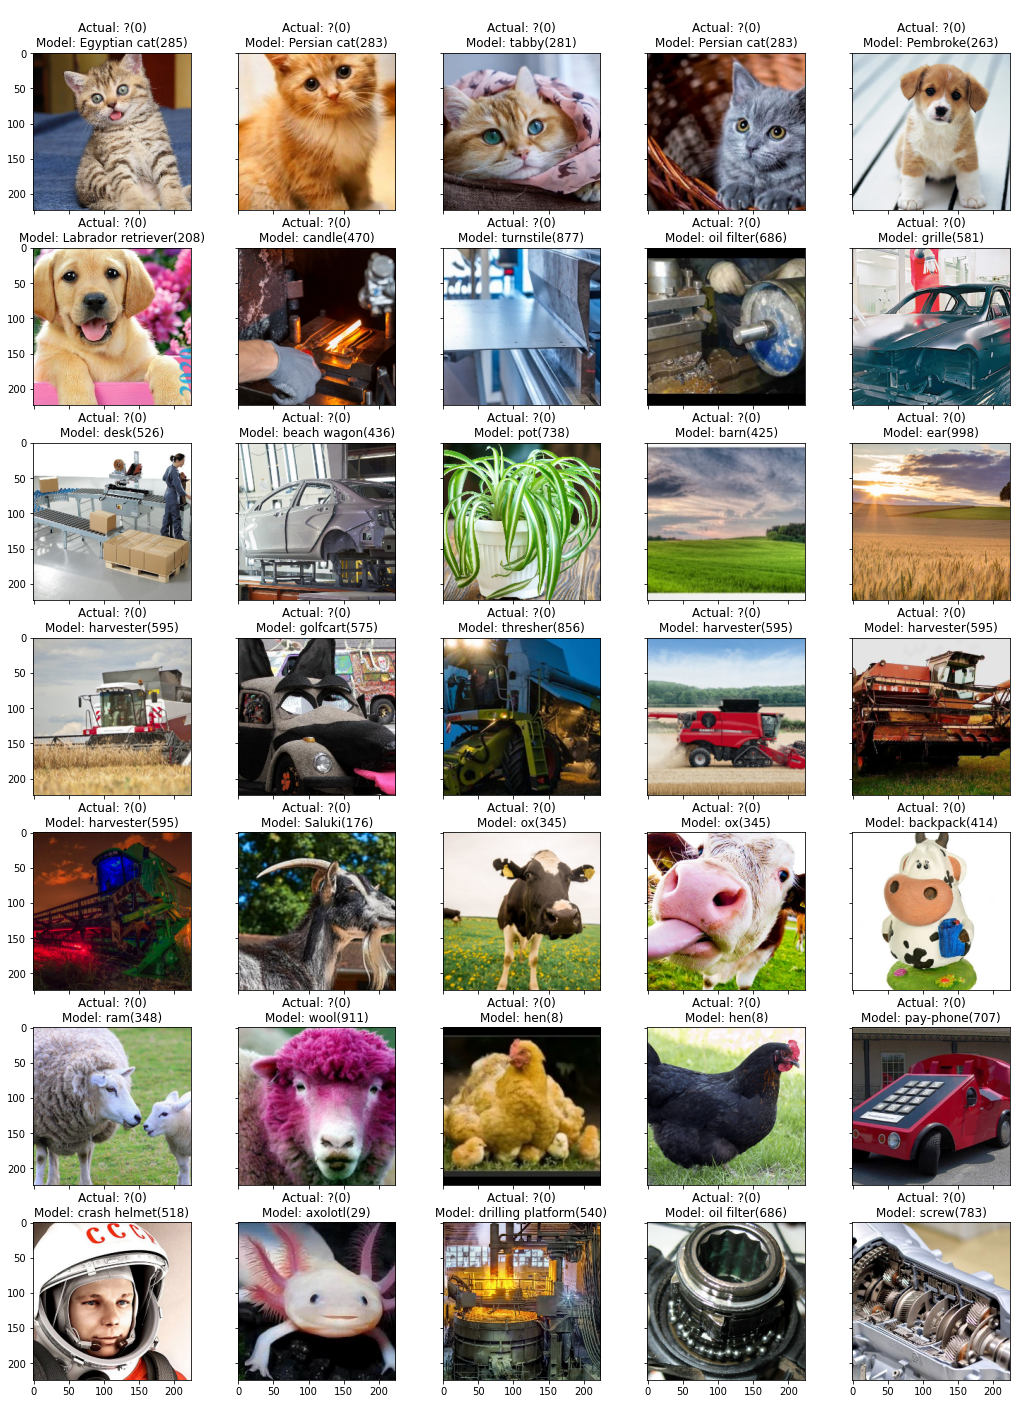

In [114]:
model = denseNet
transform = model['preprocess']
simple = UrlDataset("simple.csv", transform)

num_per_row = 5
single_size = 3.5

plot_images(simple, denormalize(simple, transform), num_per_row=num_per_row, single_size=single_size, 
            labels = simple.classes, model=model['model'], model_labels=model['weights'].meta["categories"])

# Подготовка датасета для донастройки модели

Предположим, что необходимло разработать "робота", собирающего мусор на улице двух типов - смятые бутылки из под воды и алюминевые банки для последующей переработки. Одной из подсистем такого робата будет система компьютерного зрения, которая должна будет определять, какой объект находится перед камерой (в нашем "учебном" случае это может быть только пластиковая буфтылка из под воды или красная алюминевая банка. В реальной ситуации число типов объектов наверняка будет исчисляться сотнями и тысячами).

Для донастройки библиотечных моделей первым дело необходимо сформировать два датасета, один для настройки выходных слоев нейронной сети, другой - для валидации новой модели (проверки её качества). В обоих случаях датасет помимо самих изображений должен содержать метки классов, к которым эти изображения относятся.

In [117]:
%%writefile train.csv
label;url
bottle;https://thumbs.dreamstime.com/b/hand-woman-plastic-bottle-bottle-caps-littering-environment-rubbish-grass-background-concept-environmental-66329539.jpg
bottle;https://thumbs.dreamstime.com/b/%D0%BF-%D0%B0%D1%81%D1%82%D0%B8%D1%87%D0%BD%D1%8B%D0%B5-%D0%B1%D1%83%D1%82%D1%8B-%D0%BA%D0%B8-%D0%BC%D0%B8%D0%BD%D0%B5%D1%80%D0%B0-%D1%8C%D0%BD%D0%BE%D0%B9-%D0%B2%D0%BE-%D1%8B-%D0%BD%D0%B0-%D1%82%D1%80%D0%B0%D0%B2%D0%B5-%D0%B2-%D0%BF%D0%B0%D1%80%D0%BA%D0%B5-%D0%B7%D0%B0%D1%81%D0%B0%D1%80%D0%B8%D0%B2%D0%B0%D1%82%D1%8C-83684883.jpg
bottle;https://image.shutterstock.com/image-photo/empty-plastic-bottles-on-ground-600w-1492801013.jpg
bottle;https://st2.depositphotos.com/3518393/9703/i/950/depositphotos_97034480-stock-photo-plastic-bottles-of-mineral-water.jpg
bottle;https://st2.depositphotos.com/3518393/12355/i/950/depositphotos_123557804-stock-photo-plastic-bottle-of-mineral-water.jpg
bottle;https://avatars.mds.yandex.net/i?id=7ce64bc3d8da7aa9e914715557a1f1c3-5501647-images-thumbs&ref=rim&n=33&w=338&h=225
bottle;https://avatars.mds.yandex.net/i?id=ae8cb27458571d7965294b7bd01dcbe4-4571079-images-thumbs&ref=rim&n=33&w=339&h=225
bottle;https://avatars.mds.yandex.net/i?id=1c2272968ac49de405d9263ef2d98ba7-5869064-images-thumbs&ref=rim&n=33&w=306&h=225
bottle;https://avatars.mds.yandex.net/i?id=c69e593e7e69cb87c5f069b19de17111-5910728-images-thumbs&ref=rim&n=33&w=338&h=225
bottle;https://avatars.mds.yandex.net/i?id=8608be551697e1b422aadf2a63b2bd04-5236457-images-thumbs&ref=rim&n=33&w=338&h=225
cola can;http://levik.com/i/p/2016/ny/cokelitter.jpg
cola can;https://images.squarespace-cdn.com/content/v1/57a3b84220099e5233bf6e06/1478706738460-011AL5D104EN633A35RD/image-asset.jpeg
cola can;https://thumbs.dreamstime.com/z/%D1%81%D0%B1%D1%80%D0%BE%D1%88%D0%B5%D0%BD%D0%BD%D0%B0%D1%8F-%D0%BF%D1%83%D1%81%D1%82%D0%B0%D1%8F-%D0%BA%D0%BE%D0%BD%D1%81%D0%B5%D1%80%D0%B2%D0%BD%D0%B0%D1%8F-%D0%B1%D0%B0%D0%BD%D0%BA%D0%B0-%D0%BA%D0%BE%D0%BA%D0%B0-%D0%BA%D0%BE%D0%BB%D1%8B-%D0%BA%D0%BE%D0%BA%D1%81%D0%B0-%D0%B2-%D1%83%D0%BB%D0%B8%D1%86%D0%B5-%D0%B4%D1%83%D0%B1%D0%BB%D0%B8%D0%BD%D0%B5-148182302.jpg
cola can;https://thumbs.dreamstime.com/z/crushed-coca-cola-tin-can-floor-94962686.jpg
cola can;http://blogga.ru/image/days/20051023/gauss04.jpg
cola can;https://i.ytimg.com/vi/EsjwaeWra5Q/maxresdefault.jpg
cola can;https://gsminfo.com.ua/wp-content/uploads/2022/03/d1f5e5f0a661c4119af7e8ab87871f9259d9ea8c.png
cola can;https://www.nearbyme2.com/wp-content/uploads/2020/08/Aluminum-Cans-1160x653.jpg
cola can;http://justerz.ru/wp-content/uploads/2011/06/cola1.jpg
cola can;https://image.shutterstock.com/image-photo/putrajaya-malaysia-july-14th-2015-260nw-296969408.jpg

Overwriting train.csv


In [34]:
%%writefile test.csv
label;url
bottle;https://www.colinodell.com/sites/default/files/styles/responsive/public/2017-06/rsz_litter-waste-bottle-forest_0.jpg?itok=vlEtkTNP
bottle;https://st4.depositphotos.com/2276657/29346/i/1600/depositphotos_293466072-stock-photo-plastic-bottle-on-ground.jpg
bottle;https://thumbs.dreamstime.com/z/empty-discarded-plastic-water-bottle-forest-laying-dry-leaves-215879287.jpg
bottle;https://thumbs.dreamstime.com/z/%D0%B1%D1%83%D1%82%D1%8B-%D0%BA%D0%B0-%D1%81-%D0%B2%D0%BE-%D0%BE%D0%B9-%D1%8E%D0%B1%D0%B8%D0%BC%D1%87%D0%B8%D0%BA%D0%B0-%D0%BD%D0%B0-%D1%82%D1%80%D0%B0%D0%B2%D0%B5-66683778.jpg
bottle;https://thumbs.dreamstime.com/z/%D0%BF%D0%BB%D0%B0%D1%81%D1%82%D0%BC%D0%B0%D1%81%D1%81%D0%B0-%D1%81%D0%B1%D1%80%D0%BE%D1%88%D0%B5%D0%BD%D0%BD%D0%B0%D1%8F-%D0%BD%D0%B0%D0%BF%D0%B8%D1%82%D0%BA%D0%BE%D0%BC-19082278.jpg
cola can;https://avatars.mds.yandex.net/get-ynews/1774358/136e39fa79cb9680ace51099af0c979e/800x400
cola can;https://sun9-76.userapi.com/impf/c638421/v638421746/24714/0Z_P4OYW5ms.jpg?size=320x571&quality=96&sign=45238bf82b36735ad1e94e6cd6a70052&c_uniq_tag=Vp8QpTMKfRh11FMK5VNI3l9d58Zj1shiMmShtfS4uJI&type=album
cola can;https://pbs.twimg.com/media/FImbfh6X0AIcqsk.jpg
cola can;https://www.happyhey.com/images/coca-cola-tab/232.jpg
cola can;https://thumbs.dreamstime.com/b/%D0%B1%D0%B5%D0%BB%D0%B0%D1%80%D1%83%D1%81%D1%8C-%D0%BC%D0%B8%D0%BD%D1%81%D0%BA-%D0%BE%D0%B5-%D0%B8%D1%8E%D0%BD%D1%8F-%D0%B6%D0%B5%D1%81%D1%82%D1%8F%D0%BD%D0%B0%D1%8F-%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0-coca-cola-%D0%B2-%D1%82%D1%80%D0%B0%D0%B2%D0%B5-%D0%BA%D0%BE%D0%BD%D1%86%D0%B5-%D1%82%D1%80%D0%B0%D0%B2%D1%8B-%D0%B2%D0%B2%D0%B5%D1%80%D1%85-188008802.jpg

Overwriting test.csv


Датасет в библиогтеки PyTorch представлен базовым классом Dataset, описывающий способ загрузки и трансформации набора данных по запросу. 
Начнем с описания процесса "подгрузки" изображений по url и лэйблу из CSV-файла с описанием датасета.

После подготовки класса со сценарием загрузки изображений, его можно проверить путем визуализации с помощью библиотеки Matplotlib.

------------------------------ Train dataset ------------------------------


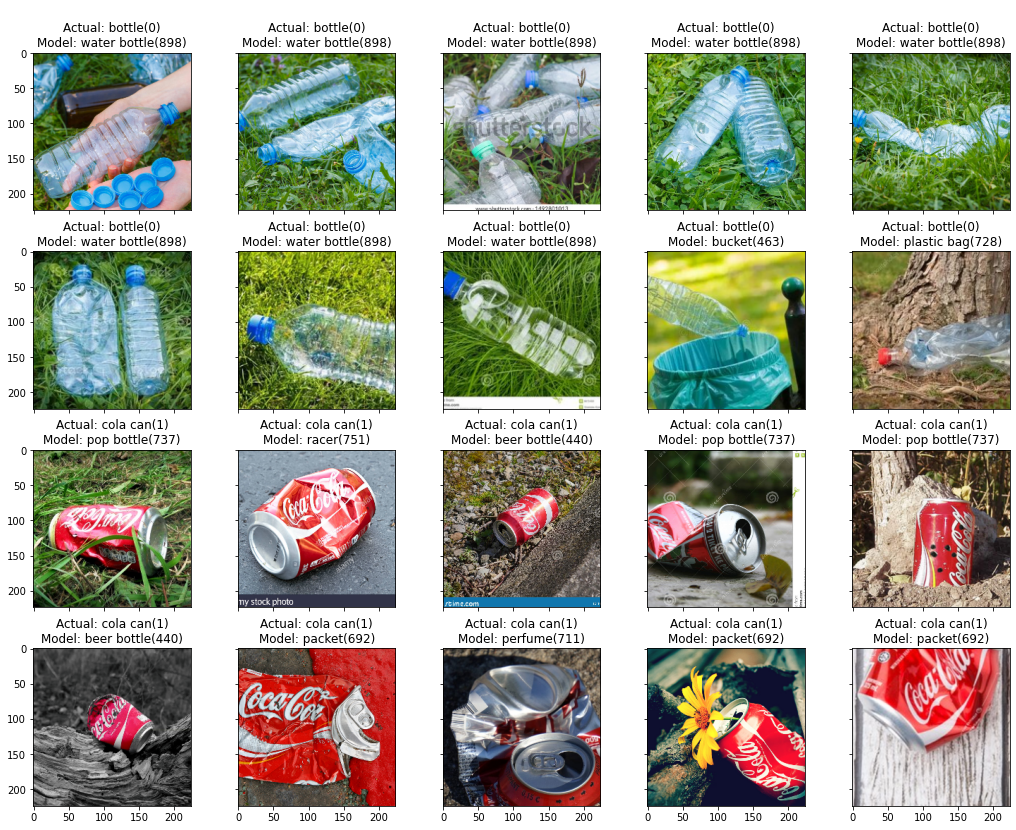

------------------------------ Test dataset ------------------------------


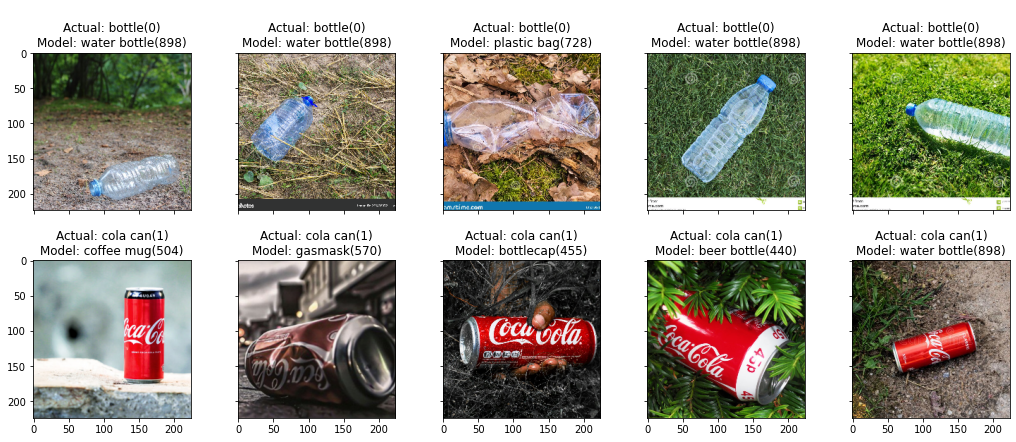

In [118]:
model = resNet50
transform = model['preprocess']
train = UrlDataset("train.csv", transform)
test = UrlDataset('test.csv', transform)

num_per_row = 5
single_size = 3.5

print('-'*30  + ' Train dataset ' + '-'*30)
plot_images(train, denormalize(train, transform), num_per_row=num_per_row, single_size=single_size, 
            labels = train.classes, model=model['model'], model_labels=model['weights'].meta["categories"])
print('-'*30  + ' Test dataset ' + '-'*30)
plot_images(test, denormalize(test, transform), num_per_row=num_per_row, single_size=single_size, 
            labels = test.classes, model=model['model'], model_labels=model['weights'].meta["categories"])

# Донастройка предобученного классификатора
Донастройка происходит за счет переобучения выходных слоев глубинной нейронной сети, отвечающих за различие частных деталей разных классов (https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

Для запуска процесса обучения необходим вспомогательный класс-обертка Dataloader, который позволяет объединять и разбивать наборы данных, заданные с помощью Dataset на фрагменты. Это необходимо, например, для параллелизации процесса настройки в ансамблях моделей, когда выборка разбивается на подвыборки и настройка происходит в  независимых процессах.



In [37]:
from torch.utils.data import DataLoader

dataloader = [
    {
        'train': True,
        'loader': DataLoader(train, batch_size=4, shuffle=True, num_workers=2)
    },
    {
        'train': False,
        'loader': DataLoader(test, batch_size=4, shuffle=True, num_workers=2)
    }
]

Current environment has no GPU support


## Задание для самостоятельного исследования
1. В заданной индивидуально категории объектов собрать набор изображений (датасет), который будет обладать следующими характеристиками:
- выбрать 2 целевых объекта для распознавания из заданной категории
- для 50% выборки найти в интернете различные изображения объекта из класса 1
- остальные 50% выборки для второго класса
- использовать различную освещенность объектов (день, ночь, сумерки, на рассвете/закате)
- использовать различный угол взгляда (фронтальная, сбоку, сверху, снизу, в 3/4)
Размер датасета - 100 изображений.

2. Провести классификацию выбранных изображений с использованием преднастроенных коэффициентов для не менее 3х моделей. В отчете привести примеры успешных/неуспешных результатов (12 примеров - по 3 для каждого класса и успешной/неуспешной классификации). Вычислить общую метрику классификации.

3. Провести донастройку модели на собранный датасет и провести классификацию на выбранном наборе данных. Разбить изображения на часть для настройки (80% датасета) и часть для валидации (20% датасета). В отчете привести примеры успешных/неуспешных результатов (12 примеров - по 3 для каждого класса и успешной/неуспешной классификации). Вычислить общую метрику классификации.